# 111261012 張晉瑜

# 底下是202421 資料讀取

In [21]:
#20241229 training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
# list the data to traing and testing
train_data_list = []
test_data_list = []
deg_labels = []
for angle in range(0, 181, 45):
    train_data_list.append(f"./training_data/deg{angle:03}_1.wav")
    test_data_list.append(f"./training_data/deg{angle:03}_2.wav")
    deg_labels.append(f"deg{angle:03}")

77
230.60199546485262


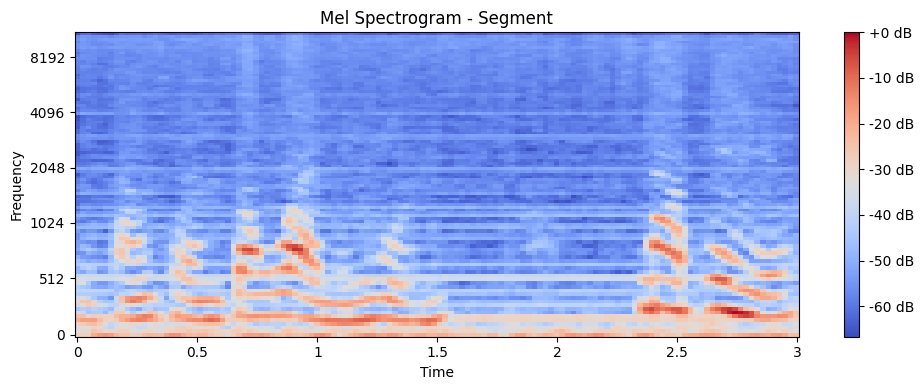

In [5]:
import matplotlib.pyplot as plt
import librosa.display



y, sr = librosa.load(train_data_list[0])  # 加载音频
segment_samples = sr * 3  # 每次切片的步长（3 秒）
sample_size = sr * int(3 / 2)  # 每个切片的长度（1.5 秒）
l = []  # 用于存储切片的 Mel 频谱

for i in range(0, len(y), segment_samples):
    segment = y[i:i + sample_size]

    # 如果 segment 长度不足 sample_size，进行填充
    if len(segment) < sample_size:
        segment = np.pad(segment, (0, sample_size - len(segment)), mode='constant')

    # 计算 Mel 频谱
    mel_spect = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=80)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    l.append(mel_spect)

print(len(l))


print(len(y)/sr)
i = segment_samples*56
sample_size = segment_samples
segment = y[i:i + sample_size]

# 如果 segment 长度不足 sample_size，进行填充
if len(segment) < sample_size:
    segment = np.pad(segment, (0, sample_size - len(segment)), mode='constant')
# 计算 Mel 频谱
mel_spect = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=100)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
l.append(mel_spect)


plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spect, sr=sr, hop_length=512, x_axis='time', y_axis='mel', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram - Segment')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# 底下是dataset架構

In [22]:
class trans_dataset(Dataset):
    def __init__(self, file_paths, labels, segment_duration=3, n_mels=200):
        """
        初始化数据集
        :param file_paths: 音频文件路径列表
        :param labels: 每个文件对应的标签列表
        :param segment_duration: 每个分段的时长（秒）
        :param n_mels: Mel 频谱的频带数
        """
        self.file_paths = file_paths
        
        # 创建标签映射
        self.label_to_index = {label: idx for idx, label in enumerate(set(labels))}
        self.index_to_label = {idx: label for label, idx in self.label_to_index.items()}
        self.labels = [self.label_to_index[label] for label in labels]  # 转换为整数标签
        
        self.segment_duration = segment_duration
        self.n_mels = n_mels
        self.samples = []  # 存储分割后的样本及其对应标签
        
        self._prepare_samples()
    
    def _prepare_samples(self):
        """对音频文件进行切片，生成多个样本"""
        for file_path, label in zip(self.file_paths, self.labels):
            y, sr = librosa.load(file_path)
            segment_samples = sr * self.segment_duration
            sample_size = sr * int(self.segment_duration / 2)
            for i in range(0, len(y), segment_samples):
                segment = y[i:i + sample_size]
                
                mel_spect = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=self.n_mels)
                mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
                self.samples.append((mel_spect, label))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        mel_spect, label = self.samples[idx]
        mel_spect = torch.tensor(mel_spect, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return mel_spect, label


# 加入data set

In [23]:
train_dataset = trans_dataset(train_data_list, deg_labels, segment_duration=3, n_mels=80)
test_dataset = trans_dataset(test_data_list, deg_labels, segment_duration=3, n_mels=80)
print(len(train_dataset)/len(deg_labels))

77.0


# 定義model

### 2 conv. 2 pool.

In [78]:
class AudioClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出: (32, 40, 22)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出: (64, 20, 11)

            # 新增一层卷积，不增加池化
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()  # 输出: (128, 20, 11)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # 展平大小: 128 * 20 * 11 = 28160
            nn.Linear(128 * 20 * 11, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # 添加 Dropout
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


### 2 conv. 1 pool.

In [66]:
class AudioClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 保留第一层池化，输出: (32, 40, 22)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # 展平
            nn.Linear(64 * 40 * 22, 128),  # 64 * n_mels/2 * time_steps/2，确保与输入形状一致
            nn.ReLU(),
            nn.Dropout(0.5),  # 添加 Dropout
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


### 2 conv. 0 pool.

In [60]:
class AudioClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # 展平
            nn.Linear(64 * 80 * 44, 128),  # 64 * n_mels * time_steps，确保与输入形状一致
            nn.ReLU(),
            nn.Dropout(0.5),  # 添加 Dropout
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

### 3 conv. 2 pool.

In [72]:
class AudioClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出: (32, 40, 22)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出: (64, 20, 11)

            # 新增一层卷积，不增加池化
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()  # 输出: (128, 20, 11)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # 展平大小: 128 * 20 * 11 = 28160
            nn.Linear(128 * 20 * 11, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # 添加 Dropout
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


# 開始訓練

In [74]:
print(model)

AudioClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=5, bias=True)
  )
)


In [73]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioClassifier(len(deg_labels))
model = model.to(device)
print(f"Model is on device: {next(model.parameters()).device}")

Model is on device: cuda:0


In [75]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # 1e-5 是 L2 正则化的强度

# 训练模型
epochs = len(train_dataset)
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for mel_spect, label in train_loader:
        # 添加一个通道维度以匹配 CNN 的输入格式
        mel_spect = mel_spect.to(device)  # 将输入数据移动到 GPU
        label = label.to(device)  # 将标签也移动到 GPU
        mel_spect = mel_spect.unsqueeze(1)  # (batch_size, 1, n_mels, time_steps)

        optimizer.zero_grad()
        outputs = model(mel_spect)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")



Epoch 1/385, Loss: 2.4144
Epoch 2/385, Loss: 1.6116
Epoch 3/385, Loss: 1.6146
Epoch 4/385, Loss: 1.6119
Epoch 5/385, Loss: 1.6078
Epoch 6/385, Loss: 1.6107
Epoch 7/385, Loss: 1.6075
Epoch 8/385, Loss: 1.6107
Epoch 9/385, Loss: 1.6111
Epoch 10/385, Loss: 1.6110
Epoch 11/385, Loss: 1.6103
Epoch 12/385, Loss: 1.6102
Epoch 13/385, Loss: 1.6116
Epoch 14/385, Loss: 1.6084
Epoch 15/385, Loss: 1.6100
Epoch 16/385, Loss: 1.6080
Epoch 17/385, Loss: 1.6101
Epoch 18/385, Loss: 1.6092
Epoch 19/385, Loss: 1.6103
Epoch 20/385, Loss: 1.6093
Epoch 21/385, Loss: 1.6088
Epoch 22/385, Loss: 1.6105
Epoch 23/385, Loss: 1.6087
Epoch 24/385, Loss: 1.6094
Epoch 25/385, Loss: 1.6084
Epoch 26/385, Loss: 1.6086
Epoch 27/385, Loss: 1.6091
Epoch 28/385, Loss: 1.6088
Epoch 29/385, Loss: 1.6095
Epoch 30/385, Loss: 1.6095
Epoch 31/385, Loss: 1.6115
Epoch 32/385, Loss: 1.6101
Epoch 33/385, Loss: 1.6105
Epoch 34/385, Loss: 1.6090
Epoch 35/385, Loss: 1.6104
Epoch 36/385, Loss: 1.6103
Epoch 37/385, Loss: 1.6099
Epoch 38/3

# test dataset並輸出結果

Classification Report:
              precision    recall  f1-score   support

      deg000       0.00      0.00      0.00        77
      deg180       0.00      0.00      0.00        77
      deg045       0.00      0.00      0.00        77
      deg135       0.00      0.00      0.00        77
      deg090       0.20      1.00      0.33        77

    accuracy                           0.20       385
   macro avg       0.04      0.20      0.07       385
weighted avg       0.04      0.20      0.07       385

Overall Accuracy: 0.2000


c:\Users\Chang Yu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chang Yu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chang Yu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

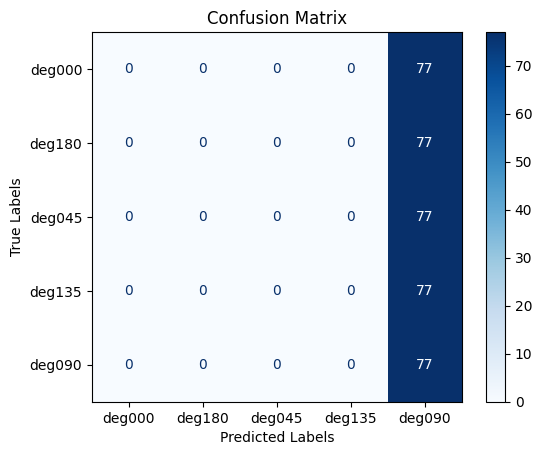

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
# 模型评估函数
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for mel_spect, labels in test_loader:
            # 移动数据到 GPU
            mel_spect = mel_spect.to(device)
            labels = labels.to(device)
            mel_spect = mel_spect.unsqueeze(1)  # 增加通道维度

            # 模型预测
            outputs = model(mel_spect)
            _, predictions = torch.max(outputs, 1)

            # 保存标签和预测结果
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    return all_labels, all_predictions

# 混淆矩阵绘制函数
def plot_confusion_matrix(labels, predictions, class_names):
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    disp.ax_.set_title("Confusion Matrix")
    disp.ax_.set_xlabel("Predicted Labels")
    disp.ax_.set_ylabel("True Labels")
    return cm

# 模型评估
labels, predictions = evaluate_model(model, test_loader)

# 类别名称
class_names = list(test_dataset.label_to_index.keys())  # 提取类别名称
labels_list = list(range(len(class_names)))  # 确保类别标签正确

# 绘制混淆矩阵
cm = plot_confusion_matrix(labels, predictions, class_names)

# 打印分类报告
print("Classification Report:")
print(classification_report(labels, predictions, target_names=class_names, labels=labels_list))

# 打印总体准确率
accuracy = accuracy_score(labels, predictions)
print(f"Overall Accuracy: {accuracy:.4f}")
